In [199]:
import json
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import multiprocessing
import numpy as np
import shutil 
import preprocessor as p

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS 

# Set of stopwords from Stone, Denis, Kwantes
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk import classify
from nltk import NaiveBayesClassifier

from textblob import TextBlob
import itertools 

import pickle

from sklearn.linear_model import LinearRegression
import pandas_profiling

import statsmodels.api as sm

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vinhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%run helper_functions.py

### Pre-processing

In [155]:
#Combine all files into one

with open('output_file.txt','wb') as wfd:
    for f in ['twitter_data.txt','twitter_data_c2.txt',
              'twitter_data_c2_pt2.txt','twitter_data_c2_pt3.txt', 
              'twitter_data_c2_pt4.txt', 'twitter_data_c2_pt5.txt', 
              'twitter_data_c2_pt6.txt', 'twitter_data_c2_pt7.txt',
             'twitter_data_c2_pt8.txt','twitter_data_c2_pt9.txt',
              'twitter_data_c2_pt10.txt','twitter_data_c2_pt11.txt']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

### Read in and subset data

In [156]:
#read in data as chunks
df = pd.read_json('output_file.txt', lines = True)

In [157]:
#only keep variables needed
df = df[["id_str", "text", "place", "coordinates", "created_at", "lang", "possibly_sensitive","retweeted" ]]

In [158]:
#don't include retweets
keyword_column_boolean(df, ['RT'])
print("full df:", len(df))
df = df[df['RT']==False]
print("after RT removal:", len(df))

full df: 97816
after RT removal: 53176


In [159]:
#booleans for each diet
diet_list = ['keto','whole30','glutenfree','mediterraneandiet','lowfat', 'atkins', 'paleo', 'celeryjuice']
keyword_column_boolean(df, diet_list)

#fix Place field
#fill None with 0
filled = df['place'].fillna(0)
#replace old column
df["place"] = filled
# #mask
place = df[df['place'] != 0]
place.reset_index(inplace=True)

#pull out bounding box from place
df_place = [i for i in df["place"] if i] 
df_place_2 = pd.DataFrame(list(np.array(df_place)))

city = df_place_2[["name","country_code"]]

bounding_box = pd.DataFrame(list(np.array(df_place_2["bounding_box"])))
bounding_box.rename(columns={'coordinates': 'bounding_box'}, inplace=True)

#add to original df to get df we want
df_location = pd.concat([place, bounding_box], axis=1, join='inner')
df_location = pd.concat([df_location, city], axis=1, join='inner')
print("has location data:", len(df_location))

has location data: 2692


In [160]:
#limit to only english for analysis
df_location = df_location[df_location['lang'] == 'en']
print("after english removal:", len(df_location))

after english removal: 2154


In [161]:
#limit to only US for analysis
df_location = df_location[df_location['country_code'] == 'US']
print("after non-US removal:", len(df_location))

after non-US removal: 1494


In [162]:
#clean tweets - remove URLs, smileys, mentions, emojis

p.set_options(p.OPT.URL, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.EMOJI) 


text_list = list(df_location["text"])

clean_text_list = []
for tweet in text_list:   
    clean_text_list.append(p.clean(tweet))

df_location["text_clean"] = clean_text_list 

In [163]:
#manually delete for now. eventually would like to do a hieararchy where if place is missing 
# and coordinates is not, fill with coordinates

df_location = df_location[df_location["id_str"] != 1141697585700204544]

In [164]:
#fix index
df_location2 = df_location.reset_index()
df_location3 = df_location2.drop(["index", "level_0"], axis = 1)
df_location3['index'] = df_location3.index

#final df
df_clean = df_location3

### Topic modeling using LDA

In [166]:
stemmer = PorterStemmer()

# create a new frame with only the cleaned text (tweet) and index
documents_v = df_clean[['text_clean', "index"]]

print(documents_v[:10])

                                          text_clean  index
0  you should make Keto meal versions of food you...      0
1  Today is a good day #sanantonio #glutenfree #h...      1
2  Have you tried our new Classic Cheeseburger? O...      2
3  I love when I walk into a grocery store for th...      3
4  Sausage and Black Olive pizzas in and do Antip...      4
5  I just had a customer tell me that the keto di...      5
6  This just made me laugh! Keto friends know. Th...      6
7  Perfect sunny Seattle day at my favorite brewe...      7
8  Enjoying a Grapefruit IPA on a perfect sunny S...      8
9  It's a hot trend now smh. They'd keto water an...      9


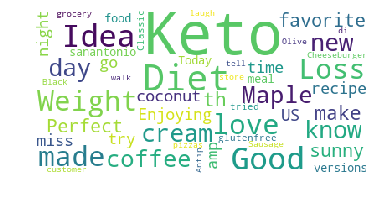

In [208]:
#Word cloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=50,
                          max_font_size=70, 
                          random_state=42,
                          collocations=False
                         ).generate(str(documents_v["text_clean"]))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1800)

In [167]:
#compare a tweet before and after preprocessing
doc_sample = documents_v[documents_v['index'] == 10].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Is', 'the', 'Keto', 'Diet', 'a', 'Good', 'Idea', 'For', 'Weight', 'Loss?', '#feed', '#staywoke']


 tokenized and lemmatized document: 
['keto', 'diet', 'good', 'idea', 'weight', 'loss', 'fee', 'staywok']


In [168]:
#Apply to all tweets
processed_docs = documents_v['text_clean'].map(preprocess)

print(processed_docs[:11])

0      [keto, meal, version, food, like, mukbang, meal]
1     [today, good, sanantonio, glutenfre, happyplac...
2     [tri, classic, cheeseburg, angu, beef, patti, ...
3     [love, walk, groceri, store, time, favorit, gl...
4     [sausag, black, oliv, pizza, antipasta, salad,...
5     [custom, tell, keto, diet, actual, chang, mito...
6            [laugh, keto, friend, know, fresh, market]
7     [perfect, sunni, seattl, favorit, breweri, glu...
8     [enjoy, grapefruit, perfect, sunni, seattl, fa...
9                           [trend, keto, water, innov]
10    [keto, diet, good, idea, weight, loss, fee, st...
Name: text_clean, dtype: object


In [170]:
# Bag of Words 
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
# Filter out tokens that appear in
# less than 15 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.


dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(dictionary)

0 food
1 keto
2 like
3 meal
4 mukbang
5 version
6 glutenfre
7 good
8 happyplac
9 local
10 point
Dictionary(102 unique tokens: ['food', 'like', 'meal', 'glutenfre', 'good']...)


In [171]:
#create bag of words. Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:10]

[[(0, 1), (1, 1), (2, 2)],
 [(3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1)],
 [(3, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(3, 1), (12, 2), (13, 1)],
 [(14, 1), (15, 1), (16, 1)],
 [(15, 1), (17, 1)],
 [(3, 1), (8, 1)],
 [(8, 1)],
 []]

In [172]:
# TF-IDF
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.38370619629898844), (1, 0.37894146837238957), (2, 0.842124051710637)]


In [173]:
# LDA using Bag of Words and gensium

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.147*"glutenfre" + 0.060*"coffe" + 0.053*"week" + 0.044*"vegan" + 0.038*"happi" + 0.038*"love" + 0.035*"snack" + 0.033*"stop" + 0.031*"thank" + 0.027*"bacon"
Topic: 1 
Words: 0.139*"good" + 0.122*"weight" + 0.119*"diet" + 0.113*"idea" + 0.113*"loss" + 0.107*"fee" + 0.023*"meal" + 0.019*"help" + 0.016*"friend" + 0.015*"come"
Topic: 2 
Words: 0.157*"atkin" + 0.065*"like" + 0.046*"month" + 0.041*"summer" + 0.039*"diet" + 0.036*"say" + 0.035*"know" + 0.029*"peopl" + 0.029*"week" + 0.026*"thing"
Topic: 3 
Words: 0.105*"diet" + 0.091*"good" + 0.075*"know" + 0.050*"weight" + 0.049*"work" + 0.042*"review" + 0.037*"loss" + 0.037*"drink" + 0.032*"life" + 0.031*"today"
Topic: 4 
Words: 0.089*"paleo" + 0.058*"cream" + 0.056*"sugar" + 0.052*"ketogen" + 0.049*"feel" + 0.039*"come" + 0.030*"week" + 0.027*"cooki" + 0.026*"right" + 0.025*"ketolifestyl"
Topic: 5 
Words: 0.054*"year" + 0.052*"dinner" + 0.050*"food" + 0.050*"lunch" + 0.042*"glutenfre" + 0.035*"night" + 0.034*"yummi" + 0.

In [174]:
# Running LDA using TF-IDF

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.060*"like" + 0.053*"need" + 0.041*"night" + 0.038*"chicken" + 0.037*"want" + 0.035*"dinner" + 0.035*"morn" + 0.032*"happi" + 0.031*"eat" + 0.030*"delici"
Topic: 1 Word: 0.067*"work" + 0.056*"pizza" + 0.050*"diet" + 0.043*"cauliflow" + 0.041*"health" + 0.040*"carb" + 0.038*"meat" + 0.034*"cream" + 0.034*"right" + 0.030*"amaz"
Topic: 2 Word: 0.112*"glutenfre" + 0.054*"come" + 0.043*"take" + 0.041*"love" + 0.041*"day" + 0.037*"atkin" + 0.036*"chees" + 0.031*"favorit" + 0.029*"good" + 0.028*"peopl"
Topic: 3 Word: 0.067*"best" + 0.061*"help" + 0.057*"summer" + 0.057*"fast" + 0.053*"make" + 0.045*"vegan" + 0.042*"recip" + 0.034*"thank" + 0.034*"dinner" + 0.031*"tonight"
Topic: 4 Word: 0.144*"diet" + 0.098*"carb" + 0.065*"time" + 0.059*"think" + 0.051*"bacon" + 0.044*"stop" + 0.031*"delici" + 0.030*"carnivor" + 0.028*"thank" + 0.022*"today"
Topic: 5 Word: 0.113*"atkin" + 0.079*"food" + 0.074*"free" + 0.049*"gluten" + 0.044*"glutenfre" + 0.043*"sweet" + 0.040*"get" + 0.035*"su

In [175]:
# Performance Evaluation

# Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8714236617088318	 
Topic: 0.139*"good" + 0.122*"weight" + 0.119*"diet" + 0.113*"idea" + 0.113*"loss" + 0.107*"fee" + 0.023*"meal" + 0.019*"help" + 0.016*"friend" + 0.015*"come"

Score: 0.014287860132753849	 
Topic: 0.105*"diet" + 0.091*"good" + 0.075*"know" + 0.050*"weight" + 0.049*"work" + 0.042*"review" + 0.037*"loss" + 0.037*"drink" + 0.032*"life" + 0.031*"today"

Score: 0.014286983758211136	 
Topic: 0.158*"diet" + 0.057*"carb" + 0.051*"time" + 0.048*"bread" + 0.048*"go" + 0.047*"great" + 0.047*"day" + 0.035*"think" + 0.033*"get" + 0.025*"good"

Score: 0.014286057092249393	 
Topic: 0.096*"lose" + 0.079*"delici" + 0.065*"best" + 0.059*"recip" + 0.052*"amaz" + 0.051*"pizza" + 0.047*"pound" + 0.029*"good" + 0.022*"thing" + 0.022*"free"

Score: 0.014286037534475327	 
Topic: 0.157*"atkin" + 0.065*"like" + 0.046*"month" + 0.041*"summer" + 0.039*"diet" + 0.036*"say" + 0.035*"know" + 0.029*"peopl" + 0.029*"week" + 0.026*"thing"

Score: 0.014286010526120663	 
Topic: 0.096*"chicken"

### NLP SENTIMENT ANALYSIS

In [176]:
# using TextBlob calculate polarity and sentiment on clean tweets
documents_v['polarity'] = documents_v['text_clean'].map(get_tweet_polarity);
documents_v['sentiment'] = documents_v['polarity'].map(get_tweet_sentiment);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [177]:
# picking positive tweets from tweets 
ptweets = documents_v[documents_v['sentiment'] == 'positive']
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(documents_v))) 

# picking negative tweets from tweets 
ntweets = documents_v[documents_v['sentiment'] == 'negative']
# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(documents_v))) 

neutweets = documents_v[documents_v['sentiment'] == 'neutral']
# percentage of neutral tweets 
print("Neutral tweets percentage: {} %".format(100*len(neutweets)/len(documents_v)))
  

Positive tweets percentage: 49.832551908908236 %
Negative tweets percentage: 14.400535833891494 %
Neutral tweets percentage: 35.76691225720027 %


In [178]:
ptweets = ptweets.rename(columns = {'text_clean': 'text'})
ntweets = ntweets.rename(columns = {'text_clean': 'text'})
neutweets = neutweets.rename(columns = {'text_clean': 'text'})

In [179]:
#create separate dataframes for positive and negative tweets
positive_tweets = pd.concat([processed_docs,ptweets], axis=1, join='inner')
negative_tweets = pd.concat([processed_docs,ntweets], axis=1, join='inner')                         
neutral_tweets = pd.concat([processed_docs,neutweets], axis=1, join='inner')  


In [180]:
positive_tweets.head()

,text_clean,text,index,polarity,sentiment
1,"[today, good, sanantonio, glutenfre, happyplac...",Today is a good day #sanantonio #glutenfree #h...,1,0.350000,positive
2,"[tri, classic, cheeseburg, angu, beef, patti, ...",Have you tried our new Classic Cheeseburger? O...,2,0.151515,positive
3,"[love, walk, groceri, store, time, favorit, gl...",I love when I walk into a grocery store for th...,3,0.416667,positive
4,"[sausag, black, oliv, pizza, antipasta, salad,...",Sausage and Black Olive pizzas in and do Antip...,4,0.416667,positive
6,"[laugh, keto, friend, know, fresh, market]",This just made me laugh! Keto friends know. Th...,6,0.337500,positive


In [182]:
#collect all text by sentiment;
all_p_text = []
for word in positive_tweets['text_clean']:
    all_p_text.append(word)
all_p_text = list(itertools.chain.from_iterable(all_p_text))
print("\n positive:\n", all_p_text)

all_n_text = []
for word in negative_tweets['text_clean']:
    all_n_text.append(word)
all_n_text = list(itertools.chain.from_iterable(all_n_text))
print("\n negative:\n", all_n_text)

all_neut_text = []
for word in neutral_tweets['text_clean']:
    all_neut_text.append(word)
all_neut_text = list(itertools.chain.from_iterable(all_neut_text))
print("\n neutral:\n", all_neut_text)


 positive:
 ['today', 'good', 'sanantonio', 'glutenfre', 'happyplac', 'point', 'local', 'tri', 'classic', 'cheeseburg', 'angu', 'beef', 'patti', 'pound', 'griddl', 'cook', 'love', 'walk', 'groceri', 'store', 'time', 'favorit', 'glutenfre', 'product', 'foodlion', 'sausag', 'black', 'oliv', 'pizza', 'antipasta', 'salad', 'glutenfre', 'pizza', 'excel', 'laugh', 'keto', 'friend', 'know', 'fresh', 'market', 'perfect', 'sunni', 'seattl', 'favorit', 'breweri', 'glutenfreeb', 'glutenfre', 'celiac', 'vacat', 'enjoy', 'grapefruit', 'perfect', 'sunni', 'seattl', 'favorit', 'breweri', 'glutenfreeb', 'trend', 'keto', 'water', 'innov', 'keto', 'diet', 'good', 'idea', 'weight', 'loss', 'fee', 'staywok', 'hear', 'fine', 'time', 'love', 'ask', 'feel', 'watermelon', 'favorit', 'fruit', 'keto', 'fruit', 'day', 'cheat', 'keto', 'cream', 'order', 'heavi', 'cream', 'sugar', 'free', 'vanilla', 'sugar', 'free', 'hazelnut', 'ohhhh', 'buddi', 'love', 'sneaker', 'cool', 'colab', 'dumb', 'hell', 'keto', 'heaven'

In [184]:
# positive tweets feature set
pos_tweets_set = []
for tweet in positive_tweets['text_clean']:
    pos_tweets_set.append((bag_of_words(tweet, all_p_text), 'pos'))   
    
# negative tweets feature set
neg_tweets_set = []
for tweet in negative_tweets['text_clean']:
    neg_tweets_set.append((bag_of_words(tweet, all_n_text), 'neg')) 
    
# negative tweets feature set
neu_tweets_set = []
for tweet in neutral_tweets['text_clean']:
    neu_tweets_set.append((bag_of_words(tweet, all_neut_text), 'neu')) 
    
    
print (len(pos_tweets_set), len(neg_tweets_set), len(neu_tweets_set))

744 215 534


In [185]:
test_set = pos_tweets_set[:int(len(pos_tweets_set)*.2)] + neg_tweets_set[:int(len(neg_tweets_set)*.2)]+ neu_tweets_set[:int(len(neu_tweets_set)*.2)]
train_set = pos_tweets_set[int(len(pos_tweets_set)*.2):] + neg_tweets_set[int(len(neg_tweets_set)*.2):] + neu_tweets_set[int(len(neu_tweets_set)*.2):]

print(len(test_set),  len(train_set))

297 1196


In [186]:
# Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy) 
 
print (classifier.show_most_informative_features(10)) 

1.0
Most Informative Features
               coffeehol = None              pos : neg    =      1.0 : 1.0
                 michael = None              pos : neg    =      1.0 : 1.0
                   goooo = None              pos : neg    =      1.0 : 1.0
                  yummmi = None              pos : neg    =      1.0 : 1.0
                    deal = True              pos : neg    =      1.0 : 1.0
             bbfoodtruck = None              pos : neg    =      1.0 : 1.0
                dunwoodi = None              pos : neg    =      1.0 : 1.0
                   ribey = True              pos : neg    =      1.0 : 1.0
                  invent = True              pos : neg    =      1.0 : 1.0
                    corn = None              pos : neg    =      1.0 : 1.0
None


### Linear Regression

In [187]:
# read in CDC data
cities = pd.read_csv('500_Cities__City-level_Data__GIS_Friendly_Format___2018_release.csv')



In [188]:
#Workaround to get coordinates from place

list2 = [item[0] for item in df_clean["bounding_box"]]
list3 = [item[0] for item in list2]
list4 = [item[::-1] for item in list3]

df_clean["coordinate_point"] = list4

In [189]:


if __name__ == "__main__":

    # Load US_coord_dict
    US_coord_dict = load_US_coord_dict()

    # Create a new column called 'closest_major_city'
    df_clean['closest_major_city'] = df_clean.apply(lambda row: get_closest_major_city_for_US(row), axis=1)
    

In [190]:
# clean DF to use is df_location3 and document_v for scores
# documents_v.drop(['text_clean'] ,axis=1, inplace=True)
prediction = pd.concat([df_clean, documents_v], axis=1)
prediction2 = prediction.groupby(['closest_major_city','sentiment'])['polarity'].mean()
prediction2 = pd.DataFrame(prediction2)
prediction3 = prediction2.pivot_table(index='closest_major_city', columns="sentiment", values='polarity')
prediction3 =  prediction3.rename_axis(None, axis=1).reset_index() 
prediction4 = prediction3.rename(columns = {"index": 'PlaceName'})
city = prediction4["closest_major_city"].str.split(',', expand=True)
city.rename(columns = {0:"closest_city", 1: "closest_state"}, inplace=True)
prediction5 = pd.concat([city, prediction4], axis=1, join='inner')
prediction6 = pd.merge(prediction5, cities, left_on='closest_city', right_on='PlaceName')   

In [191]:
prediction6.head()

,closest_city,closest_state,closest_major_city,negative,neutral,positive,StateAbbr,PlaceName,PlaceFIPS,Population2010,...,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,Abilene,TX,"Abilene, TX",NaN,NaN,0.160000,TX,Abilene,4801000,117063,...,"(33.6, 34.1)",3.2,"( 3.1, 3.2)",3.3,"( 3.3, 3.4)",15.7,"(14.6, 16.9)",15.6,"(14.5, 16.8)","(32.45465108980, -99.7383043723)"
1,Akron,OH,"Akron, OH",NaN,0.0,0.327500,OH,Akron,3901000,199110,...,"(43.2, 43.6)",4.2,"( 4.1, 4.2)",4.1,"( 4.0, 4.2)",21.6,"(20.6, 22.5)",21.5,"(20.6, 22.4)","(41.08014449420, -81.5219213688)"
2,Albuquerque,NM,"Albuquerque, NM",-0.187500,0.0,NaN,NM,Albuquerque,3502000,545852,...,"(32.3, 32.5)",2.9,"( 2.8, 2.9)",2.9,"( 2.8, 2.9)",12.5,"(12.1, 13.0)",12.6,"(12.2, 13.1)","(35.10550257710, -106.647447696)"
3,Alexandria,VA,"Alexandria, VA",-0.166667,0.0,0.278669,VA,Alexandria,5101000,139966,...,"(30.7, 31.2)",2.0,"( 1.9, 2.0)",2.3,"( 2.2, 2.3)",9.0,"( 8.2, 10.0)",9.2,"( 8.4, 10.2)","(38.81873515570, -77.0867762661)"
4,Alhambra,CA,"Alhambra, CA",-0.100000,0.0,NaN,CA,Alhambra,600884,83089,...,"(37.7, 38.3)",2.5,"( 2.4, 2.6)",2.3,"( 2.3, 2.4)",9.2,"( 8.4, 10.0)",9.1,"( 8.4, 9.8)","(34.08397343830, -118.135514119)"


In [192]:
#drop adjusted variables, obviously highly correlated with crude measures. 

prediction7 = prediction6.filter(items=["PlaceName", "negative", "neutral", "positive",
"Population2010",
"ACCESS2_AdjPrev",
# "ARTHRITIS_AdjPrev",
"BINGE_AdjPrev",
"BPHIGH_AdjPrev",
"BPMED_AdjPrev",
"CANCER_AdjPrev",
"CASTHMA_AdjPrev",
# "CHD_AdjPrev",
"CHECKUP_AdjPrev",
"CHOLSCREEN_AdjPrev",
"COLON_SCREEN_AdjPrev",
# "COPD_AdjPrev",
"COREM_AdjPrev",
"COREW_AdjPrev",
"CSMOKING_AdjPrev",
"DENTAL_AdjPrev",
"DIABETES_AdjPrev",
"HIGHCHOL_AdjPrev",
# "KIDNEY_AdjPrev",
"LPA_AdjPrev",
"MAMMOUSE_AdjPrev",
# "MHLTH_AdjPrev",
"OBESITY_AdjPrev",
# "PAPTEST_AdjPrev",
# "PHLTH_AdjPrev",
"SLEEP_AdjPrev",
# "STROKE_AdjPrev",
# "TEETHLOST_AdjPrev"
])

In [193]:
pandas_profiling.ProfileReport(prediction7)

Number of variables,24
Number of observations,294
Total Missing (%),4.9%
Total size in memory,57.4 KiB
Average record size in memory,200.0 B
Numeric,22
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [194]:
#Linear Regression
y = prediction7["OBESITY_AdjPrev"]
X = prediction7.drop(["OBESITY_AdjPrev", "PlaceName"], axis=1).astype(float)
X['const'] = 1
X.fillna(0, inplace=True)

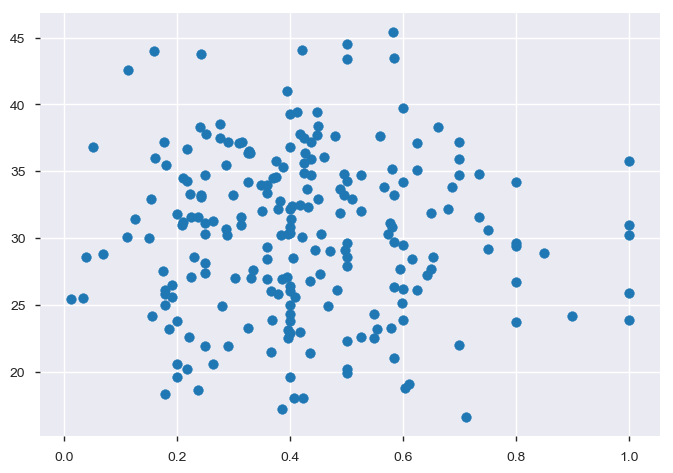

In [195]:
#look at relationship of positive tweets and obesity
prediction8 = prediction7[prediction7["positive"] > 0]
plt.scatter(prediction8["positive"], prediction8["OBESITY_AdjPrev"])

In [196]:
#fit the model
model = sm.OLS(endog=y, exog=X).fit()

In [197]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        OBESITY_AdjPrev   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     104.8
Date:                Tue, 02 Jul 2019   Prob (F-statistic):          3.34e-117
Time:                        14:59:35   Log-Likelihood:                -624.74
No. Observations:                 294   AIC:                             1293.
Df Residuals:                     272   BIC:                             1375.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
negative                 0.9304      0.676      1.377      0.170      -0.400       2.261
neutral               2.771e-10   2.14e-10      1.292      0.197   -1.45e-10    6.99e-10
positive                -0.5235      0.512     -1.023      0.307      -1.531       0.484
Population2010       -5.648e-07    2.3e-07     -2.454      0.015   -1.02e-06   -1.12e-07
ACCESS2_AdjPrev          0.1285      0.053      2.403      0.017       0.023       0.234
BINGE_AdjPrev            0.3335      0.072      4.618      0.000       0.191       0.476
BPHIGH_AdjPrev           0.5653      0.086      6.572      0.000       0.396       0.735
BPMED_AdjPrev            0.1886      0.068      2.759      0.006       0.054       0.323
CANCER_AdjPrev           3.1534      0.640      4.926      0.000       1.893       4.414
CASTHMA_AdjPrev          0.7424      0.210      3.534      0.000       0.329       1.156
CHECKUP_AdjPrev         -0.1676      0.067     -2.517      0.012      -0.299      -0.037
CHOLSCREEN_AdjPrev      -0.2861      0.084     -3.426      0.001      -0.450      -0.122
COLON_SCREEN_AdjPrev    -0.0399      0.058     -0.683      0.495      -0.155       0.075
COREM_AdjPrev           -0.0264      0.038     -0.703      0.483      -0.100       0.048
COREW_AdjPrev            0.1084      0.053      2.045      0.042       0.004       0.213
CSMOKING_AdjPrev        -0.0547      0.098     -0.559      0.576      -0.247       0.138
DENTAL_AdjPrev           0.1054      0.051      2.051      0.041       0.004       0.206
DIABETES_AdjPrev         0.9160      0.229      4.003      0.000       0.466       1.366
HIGHCHOL_AdjPrev        -0.0092      0.107     -0.086      0.932      -0.219       0.201
LPA_AdjPrev              0.1838      0.073      2.535      0.012       0.041       0.327
MAMMOUSE_AdjPrev        -0.0642      0.070     -0.923      0.357      -0.201       0.073
SLEEP_AdjPrev           -0.1191      0.061     -1.946      0.053      -0.240       0.001
const                   -8.8182      6.978     -1.264      0.207     -22.555       4.919
==============================================================================
Omnibus:                        0.214   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.108
Skew:                          -0.042   Prob(JB):                        0.948
Kurtosis:                       3.042   Cond. No.                     2.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.74e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""